In [2]:
import numpy as np

import pandas as pd

import pycountry_convert as pc # for filtering all European countries

import matplotlib.pyplot as plt

# from collections import defaultdict

import itertools

from pingouin import mixed_anova, read_dataset # for mixed/model ANOVA

from Preprocessing_Functions import generate_test_values_matrix
from Preprocessing_Functions import do_np_post_hoc_tests
from Preprocessing_Functions import create_dummies_col

# from IPython.core.debugger import set_trace
# from sklearn.svm import SVC # "Support vector classifier"

# used to test for normal distribution before subsituting NaN
from scipy.stats import shapiro 
import scipy.stats as stats

#activate inline plotting to show figures inside the Jupyter Notebook
%matplotlib inline

import seaborn as sns

# set styles for seaborn plots
sns.set_style('darkgrid')
sns.set_color_codes(palette='pastel')

# Business Understanding

In the course I took, we looked at factors influencing/correlating with salary but the analysis focused on satisfaction or hours of work per week. The aim of the present analysis was to dig deeper into potential confounding factors in the dataset by looking at three specific questions:

- Question 1: is there a difference in total compensation by continent?

- Question 2: does compensation in Europe and North America depend on size of the organisation?

- Question 3: Do people with a PhD in North America and Europe receive a higher compensation compared to people with another type of university degree or without a university degree?

# Data Understanding and Data Preparation

In the following, data is read in and cleaned by
 - removing all columns with less than 40% values
 - removing all NaN values from the column to predict (e.g. the converted salary)
 - removing columns which are derivatives of each other as they are linearly dependent and thus do not help in explaining variance in the dataset
 - converting columns to numeric values where appropriate (e.g. hours of work per week)
 - removing outliers from numeric columns based on column-specific premises (e.g. work hours of more than 126h per week)
 - filling in NaN values in columns based on the distribution of data in that column (mean is used for normally distributed data, median is used for non-normal distributions)

As the dataset is too large to upload it on Github, please download it from <br>
https://drive.google.com/file/d/1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB/view?usp=sharing
<br>

In [3]:
df = pd.read_csv("developer_survey_2020/survey_results_public.csv")
schema = pd.read_csv("developer_survey_2020/survey_results_schema.csv")

In [4]:
# drop all columns for which less than 40% of data were registered
dfs = df.dropna(axis=1, thresh=np.round(df.shape[0]*0.4))

# get the index of all NaN values in 'ConvertedComp' and remove 
# corresponding rows from the dataframe
idx = np.array(dfs['ConvertedComp'].isna())
dfs = dfs.drop(axis=0, index=df.index[idx])

In [5]:
# Select relevant subset of columns
# CompFreq and CompTotal are direct derivatives of ConvertedComp and would 
# distort results
idx_remove = ['CompFreq', 'Respondent', 'CompTotal', 'DatabaseDesireNextYear',
              'JobSeek', 'DatabaseWorkedWith', 'LanguageDesireNextYear', 
              'MiscTechDesireNextYear', 'NEWCollabToolsDesireNextYear', 
              'NEWDevOps', 'NEWDevOpsImpt', 'NEWJobHunt', 
              'NEWJobHuntResearch','PurchaseWhat', 'SurveyEase', 
              'CurrencyDesc', 'SurveyLength', 'WebframeDesireNextYear', 
              'PlatformDesireNextYear','NEWPurchaseResearch', 'Ethnicity',
              'Sexuality', 'CurrencySymbol', 'NEWSOSites','SOVisitFreq']
dfs = dfs.drop(columns=idx_remove, axis=1)

# ------ CONVERT CATEGORICAL TO NUMERIC VARIABLES WHERE APPROPRIATE ------ 

# cast years of coding to numeric type by substituting with the "mean" of 
# reasonable timespans, i.e. 'More than 50 years' is substituted with 55 years
#  - assuming maximum employment duration to be 70 and start of programming 
# professionally to 15, resulting max professional coding experience is 55 
# (70-15)
dfs.YearsCodePro.replace({'Less than 1 year': '0.5', 
                          'More than 50 years': '55'}, inplace=True)
dfs.YearsCodePro = dfs.YearsCodePro.astype(np.number)

dfs.YearsCode.replace({'Less than 1 year': '0.5', 
                       'More than 50 years': '60'}, inplace=True)
dfs.YearsCode = dfs.YearsCode.astype(np.number)

dfs.Age1stCode.replace({'Older than 85': '90', 
                        'Younger than 5 years': '4'}, inplace=True)
dfs.Age1stCode = dfs.Age1stCode.astype(np.number)

## Data Understanding: Compensation values

Looking at one of our target variables, the total compensation converted to US Dollars we can see that there are quite a few extreme values for total compensation as well as for age.

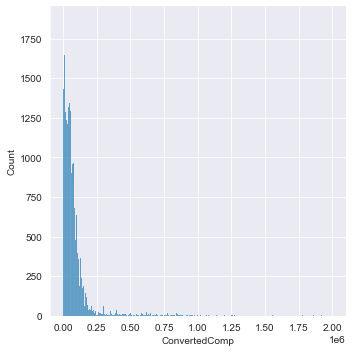

In [6]:
sns.displot(dfs['ConvertedComp'])

To check how plausible the compensation values > 1,75 Million USD are, plot them against the time people have been coding professionally as well as their age.

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


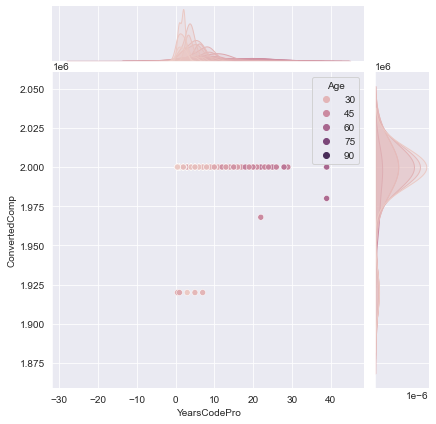

In [7]:
high_income = dfs[dfs['ConvertedComp']>1900000]
sns.jointplot(x='YearsCodePro', y='ConvertedComp', hue='Age',data=high_income)

The Converted Comp column is built from 'CompTotal' and 'CompFreq' as can be seen from the schema data below. One easy explanation for the outliers would be if somebody listed their yearly income but put 'weekly' as frequency. We can check this by looking at the CompFreq values in the (uncleaned) dataframe df.

In [8]:
print(schema.loc[schema.Column == 'ConvertedComp', 'QuestionText'].tolist())

['Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working months and 50 working weeks.']


In [9]:
print(schema.loc[schema.Column == 'CompTotal', 'QuestionText'].tolist())

['What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty.']


In [10]:
print(schema.loc[schema.Column == 'CompFreq', 'QuestionText'].tolist())

['Is that compensation weekly, monthly, or yearly?']


In [11]:
df.CompFreq[df.ConvertedComp > 1900000].describe()

count        265
unique         3
top       Weekly
freq         211
Name: CompFreq, dtype: object

## Data Preparation: Compensation values
The result supports the above hypothesis* so we exclude outliers based on the 97 percent quantile in the next step.

*although one could have a more detailed look at, e.g. the geographical location (maybe there is an area of very high payment due to increased competition for developers).

In [12]:
# ------ REMOVE OUTLIERS FROM NUMERIC COLUMNS --------

# I assume some people have listed their yearly income (e.g. 120.000) but 
# provided frequency 'weekly', resulting in very high ConvertedComp values 
# which are implausible given other data (age, work hours)
for feat in ['ConvertedComp', 'Age']:
    idx = np.array(dfs[feat] >= dfs[feat].quantile(.97))
    dfs = dfs.drop(axis=0, index=dfs.index[idx])

# assuming 6h per day minimum for eating, sleeping, buying groceries,... 
# maximum work hours per week are 126. Everything above will be substituted by
# the median dfs.replace({'WorkWeekHrs':126}, dfs['WorkWeekHrs'].median(), 
# inplace=True)
mask = dfs.WorkWeekHrs >125
dfs.loc[mask, 'WorkWeekHrs'] = dfs['WorkWeekHrs'].mean()
dfs.fillna(value={'WorkWeekHrs': dfs['WorkWeekHrs'].mean()}, inplace=True)

In [13]:
# ------ SUBSTITUTE NANs --------

# substitute with mean or median depending on distribution type
# for col in dfs.columns:
#     if dfs[col].dtype == np.number:
#         stat, p = shapiro(np.array(dfs[col]))
# #         k, p2 = stats.normaltest(np.array(dfs[col]), nan_policy='omit') 
#         if p > 0.05:
#             print(col, ': Distribution is Gaussian')
#             print('Result from normaltest: ', p2)
#             mask = dfs[col].isna()
#             dfs.loc[mask, col] = dfs[col].mean()
#             #dfs[col][dfs[col].isna()] = dfs[col].mean()
#         else:
#             print(col, ': Distribution is not Gaussian')
#             print('Result from normaltest: ', p2)
#             mask = dfs[col].isna()
#             dfs.loc[mask, col] = dfs[col].median()
#             #dfs[col][dfs[col].isna()] = dfs[col].median()   

## Data Understanding: Education Level
A second variable of interest is the level of education the respondents have. If we look at the set of unique values of that variable, we see that the description is very long which makes later plotting and analysis difficult to handle.

In [14]:
set(dfs.EdLevel)

{'Associate degree (A.A., A.S., etc.)',
 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
 'I never completed any formal education',
 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
 'Other doctoral degree (Ph.D., Ed.D., etc.)',
 'Primary/elementary school',
 'Professional degree (JD, MD, etc.)',
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
 'Some college/university study without earning a degree',
 nan}

## Data Preparation: Education Level
Thus, in order to create dummy variables for education level, we shorten
the names of the labels by replacing values in that column

In [15]:
dfs['EdLevel'].replace({'Associate degree (A.A., A.S., etc.)':'Associate',
                        'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 
                        'Bachelor',
                        'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':
                        'Master', 
                        'Other doctoral degree (Ph.D., Ed.D., etc.)':
                        'Doctorate', 
                        'Professional degree (JD, MD, etc.)':'Doctorate',
                        'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':
                        'Sec_school',
                        'Some college/university study without earning a degree':
                        'Sec_school',
                        'Primary/elementary school':'Prim_School',
                        'I never completed any formal education':'No_ed'
                       }, inplace=True)

Lastly, we create a dummy encoding of this variable which makes separate [0, 1]-encoded columns for each label in the variable

In [16]:
dfs = create_dummies_col(df_in=dfs, col='EdLevel', delim=';', 
                         delete_original=True)

Now that we have split the labels and shortened descriptions, we can join all levels of higher education in a single variable which we add as a separate column to the dataframe

In [17]:
# Dichotomize Education into higher education (i.e. minimum a university
# degree) and others (e.g. primary / secondary school)
dfs['HigherEd'] =  (dfs['EdLevel_Associate'] + dfs['EdLevel_Bachelor'] + 
                    dfs['EdLevel_Doctorate'] + dfs['EdLevel_Master'])

## Data understanding: Developer Type

If we look at the unique values in the 'Developer Type' column, we can see a huge list of semicolon-separated values which does not allow easy filtering for a specific developer type such as "Frontend Developer". We need this filtering later, because analysis of question 3 *(Do people with a PhD receive higher compensation than others)* requires to filter out people working in academia. 

In academia, the relative proportion of people with a PhD is high, as it is an entrance criterion in many countries. At the same time, Post-docs are paid by the state in a lot of countries, which means that influences on the structure of their compensation might differ from industry.

In [18]:
set(dfs.DevType)

{nan,
 'Developer, back-end;Developer, desktop or enterprise applications;Developer, embedded applications or devices;Developer, front-end',
 'Academic researcher;Data or business analyst;Designer;Developer, back-end;Developer, full-stack',
 'Developer, back-end;Developer, front-end;Developer, full-stack;DevOps specialist;Engineering manager;Product manager',
 'Developer, back-end;Developer, QA or test;Engineering manager',
 'Database administrator;Designer;Developer, back-end;Developer, desktop or enterprise applications;Developer, front-end;Developer, QA or test',
 'Database administrator;Developer, back-end;Developer, desktop or enterprise applications;Developer, embedded applications or devices;Developer, front-end;Developer, full-stack;Developer, mobile;DevOps specialist',
 'Developer, front-end;Developer, full-stack;Developer, game or graphics;Engineer, data',
 'Data or business analyst;Data scientist or machine learning specialist;Database administrator;Developer, back-end;DevOp

Looking at the schema data for DevType shows that the question allowed for multiple selection. Individual answers are separated by semicolon. I wrote a function *create_dummies_col* which deals with this by first splitting entries at a specified delimiter (here: ';') and then creating dummy (i.e. value 0/1) columns for each level of the variable

In [19]:
print(schema.loc[schema.Column == 'DevType', 'QuestionText'].tolist())

['Which of the following describe you? Please select all that apply.']


## Data Preparation: Developer Type

In [20]:
# Some items in the questionnaire allowed for multiple answers. 
# Each unique combination of these is listed as a value-concatenation 
# delimited by ';'.
for col in ['DevType', 'JobFactors']:
    if col in dfs.columns:
        dfs = create_dummies_col(df_in=dfs, col=col, delim=';', 
                                 delete_original=True)

## Data Understanding: Gender
Looking at the schema data shows that again, Gender was a multiple-selection answer. What is more, the set of unique values shows that people who marked themselves as 'Genderqueer' often chose one of either 'Male' and 'Female' on top. 

In [21]:
print(schema.loc[schema.Column == 'Gender', 'QuestionText'].tolist())

['Which of the following describe you, if any? Please check all that apply. If you prefer not to answer, you may leave this question blank.']


In [22]:
set(dfs.Gender)

{'Man',
 'Man;Non-binary, genderqueer, or gender non-conforming',
 'Non-binary, genderqueer, or gender non-conforming',
 'Woman',
 'Woman;Man',
 'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
 'Woman;Non-binary, genderqueer, or gender non-conforming',
 nan}

## Data Preparation: Gender
For easier analysis, a new column that only distinguishes male, female and genderqueer is generated.

In [23]:
# break up ';'-delimited labels into columns
dfs = create_dummies_col(dfs, 'Gender', ';', False)
dfs['Gender'] = dfs.Gender_Man + (dfs.Gender_Woman*2) + \
            (dfs['Gender_Non-binary, genderqueer, or gender non-conforming']*3)

# remove old dummies columns
dfs.drop(columns = ['Gender_Man', 
                    'Gender_Non-binary, genderqueer, or gender non-conforming', 
                    'Gender_Woman'], inplace = True)

# now 0=NaN, 1=Male, 2=Female, 3=Gender non-binary etc.
dfs.replace({'Gender':[4,5,6]}, 3, inplace=True)

# generate a column holding string data
dfs['Genderlabels'] = dfs['Gender'].copy()
dfs.replace({'Genderlabels':1}, 'Male', inplace=True)
dfs.replace({'Genderlabels':2}, 'Female', inplace=True)
dfs.replace({'Genderlabels':3}, 'Genderqueer', inplace=True)
dfs.replace({'Genderlabels':0}, None, inplace=True)

## Data Understanding: Geographical information

For answering question 1 *(does compensation differ by location)*, we need to be able to run an analysis over countries. Looking at the data in the plot below shows that there are many different country values in the dataset, which makes analyses difficult to the ensuing small sample sizes and large variable levels.

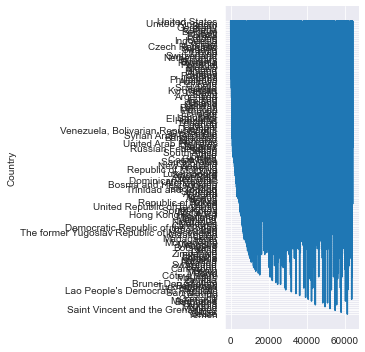

In [24]:
sns.relplot(data=dfs['Country'], kind='line', palette='Pastel')

## Data Preparation: Geographical information
One possible way of grouping data is by geographical clusters, i.e. by continents. Of course, continents may contain countries with very different general levels of payment, which might in turn also influence compensation values for developers. A more refined way could, therefore, be to group by GDP, but we do not have that information available in the dataset.

In [25]:
dfs['Country'].reset_index(drop=True)
countries = pd.Series(dfs['Country'])

# accesses the first group match of a python regex
repl = lambda m: m.group(1)
# Strips Country names to the first word, ([a-z|A-Z]*)[,].*$ and remove some 
# special cases i.e. "Venezuela, Bolivarian Republic of...'" is changed to 
# "Venezuela"
countries = countries.str.replace('([a-z|A-Z]*)[,].*$', repl, case=False)
countries = countries.str.replace('Republic of Korea', 'North Korea', 
                                  case=True)
countries = countries.str.replace('The former Yugoslav Republic of Macedonia', 
                                  'Macedonia', case=True)
countries = countries.str.replace('Hong Kong (S.A.R.)', 'Hong Kong', 
                                  regex=False)

# generate two arrays holding the country code and continent code
country_code = []
continent_code = []
for x in np.arange(0,dfs.shape[0],1):
    try:
        country_code.append(pc.country_name_to_country_alpha2(
            countries.iloc[x], cn_name_format="default"))
        continent_code.append(pc.country_alpha2_to_continent_code(
            country_code[-1]))
    except KeyError:
        if countries.iloc[x] == 'Kosovo':
            continent_code.append('EU')
            country_code.append(None)
        else:
            country_code.append(None)
            continent_code.append(None)

# add country and continent code to the dataset
dfs.insert(0, column='CountryCode', value=country_code)
# remove country names - same information content as Country Code
# dfs.drop(columns='Country', inplace=True)
dfs.insert(0, column='Continent', value=continent_code)

__Add a normalized income column__

In [26]:
# calculate mean and standard deviation per continent and add it as column 
# to the dataframe
means_stds = dfs.groupby('Continent')['ConvertedComp'].agg(['mean','std'])
means_stds.reset_index()
dfs = dfs.merge(means_stds, on='Continent')
del means_stds

# calculate the normalized compensation value per continent and add it in a 
# new column
dfs['CComp_norm'] = (dfs['ConvertedComp'] - dfs['mean']) / dfs['std']

# remove the added "mean" and "std" column from the dataframe
dfs.drop(columns=['mean', 'std'], inplace=True)

## Sanity check
To verify whether we made some big errors in data cleaning or have outliers which massively distort the data, we look at the correlation values of the numeric columns.
The results appear plausible at first glance:
- Age and years of professional coding experience are highly and positively correlated, i.e. the older you are, the longer you coded professionally
- Normalized income (ConvertedComp) and age as well as years of coding experience are moderately positively correlated, i.e. there is a tendency that you earn more the older you are and the longer you program professionally

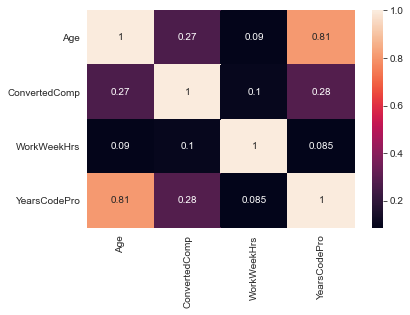

In [27]:
sns.heatmap(
    dfs[['Age', 'ConvertedComp', 'WorkWeekHrs', 'YearsCodePro']].corr(), 
    annot=True, fmt='.2g'
)
plt.savefig('Figures/CorrelationMatrix.png', bbox_inches='tight', 
            pad_inches=0.3)

# Question 1: is there a difference in total compensation by continent?
## Data Understanding
Visualize the distribution of total compensation by continent.

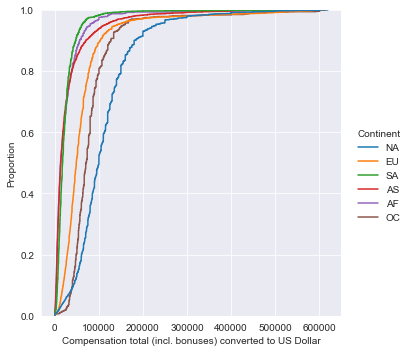

In [28]:
# plot the distribution as density estimate
plottype='ecdf'
filename = 'Figures/Compensation_by_Continent_' + plottype + '.png'

sns.displot(data=dfs, x='ConvertedComp', hue='Continent', 
            kind=plottype)
plt.xlabel('Compensation total (incl. bonuses) converted to US Dollar')
plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)

There appears to be a difference in central tendency for the distributions, indicating lower income in Asia, South America and Africa as opposed to Europe and North America. Of course there might be confounding factors such as different numbers of participants, age groups, developer types which cannot all be exluded from analysis.

To determine which test to use for inference, let us look at a boxplot of the data to see whether it is normally distributed.

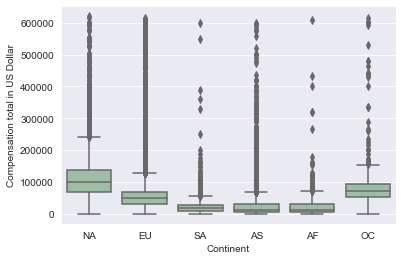

In [29]:
df = dfs[['ConvertedComp', 'Continent']].copy()
df = pd.melt(df.reset_index(), id_vars=['Continent'], 
                  value_vars=['ConvertedComp'])

sns.boxplot(x='Continent', y='value', data=df, color='#99c2a2')
filename = 'Figures/Salary_by_Continent_boxplot.png'
plt.ylabel('Compensation total in US Dollar')

plt.savefig(filename, bbox_inches='tight')
del df, filename

The data clearly is not normally distributed and it is hard to tell by visual inspection whether there are significant differences. North America, Europe and Oceania have higher means and non-overlapping standard deviations with the other continents but outliers might lead to an erroneous impression

## Perform statistical tests / inference

As the data does not look normally distributed, choose a nonparametric alternative to a two-way ANOVA.
In this case, the Kruskal-Wallis test is used because there are more than two levels, i.e. continents, of the independent variable and the data are from independent samples, i.e. each income value is from different people participating in the survey

Do Mann-Whitney tests for some pairwise comparisons of interest. 
We need to correct alpha for the number of tests we are doing, here using Bonferroni-correction for multiple comparisons.

__Functions used for test preparation (imported from Preprocessing_Functions.py)__
<ol>
    <li>generate_test_values_matrix : takes strings for factor / independent variable (X) and dependent variable (y) and generates a test matrix of size (nsamples x factor-levels) used for statistical testing.</li>
    <li>do_np_post_hoc_tests : does nonparametric pairwise comparisons for the combinations of columns in an (nsamples x factor-levels) test matrix listed in <i>indices</i></li>
</ol>

In [30]:
t_labels, t_vals, df_test = generate_test_values_matrix(
    data = dfs, y='ConvertedComp', str_X='Continent')

# as the data does not look normally distributed, due to the long tails, 
# we need to revert to the nonparametric alternative to a two-way ANOVA, e.g. 
# a Kruskal-Wallis Test
statistic, pvalue = stats.kruskal(*t_vals, nan_policy='omit')
print('P value of Kruskal-Wallis H-Test: ', pvalue)
print('H statistic of Kruskal-Wallis Test:', statistic)

Number of observations for  AF =  877
Number of observations for  AS =  5837
Number of observations for  EU =  14310
Number of observations for  NA =  9032
Number of observations for  OC =  870
Number of observations for  SA =  1854
P value of Kruskal-Wallis H-Test:  0.0
H statistic of Kruskal-Wallis Test: 13093.603488072049


## Evaluation of the results

The p-value is smaller than the chosen alpha of 0.05 and can be considered significant, meaning that compensation differs significantly between continents.

In [31]:
## Calculate the post-hoc tests for the Kruskal-Wallis test

# get all possible group combinations
comb = itertools.combinations(np.arange(0,len(t_labels)), 2)
indices = [i for i in comb]
labels = [t_labels[i[0]] + ' vs. ' + t_labels[i[1]] for i in indices]

do_np_post_hoc_tests(t_vals, labels, indices, 0.05, True)

# clear variables we no longer need
# del labels, indices, t_vals, t_labels, statistic, pvalue, df_test

Alpha value after Bonferroni correction:  0.0033333333333333335 



,label,Pval,U-stat,is_significant
0,AF vs. AS,1.435478e-01,2502550.0,False
1,AF vs. EU,8.366131e-220,2289227.5,True
2,AF vs. NA,0.000000e+00,615021.5,True
3,AF vs. OC,4.943716e-192,70119.0,True
4,AF vs. SA,8.511964e-08,712370.5,True
5,AS vs. EU,0.000000e+00,16536235.5,True
6,AS vs. NA,0.000000e+00,5331846.5,True
7,AS vs. OC,3.808651e-289,603952.5,True
8,AS vs. SA,1.968252e-13,4806424.5,True
9,EU vs. NA,0.000000e+00,27852710.0,True


The post-hoc results show significant test results for all pairwise comparisons except Africa vs. Asia.

To answer the question: the data supports the assumption that the geographical location where people work lead to differences in compensation. Please note, however, that there might be a multitude of other factors that could explain this (biases in the branch where people work, age, number of participants in the survey, usage of other tools in other countries,...)

# Question 2: Does compensation in Europe and North America depend on the size of the organisation?

To explore one potential, other, confounding factor, I aimed to look whether company size influences compensation. I did the analysis only for two continents and processed data separately.

## Data Preparation
Transform labels in the OrgSize column to make it more readable

In [32]:
# ------ Shorten labels in OrgSize to make plots readable -------
df = dfs.copy()
df.OrgSize = df.OrgSize.str.replace(' employees','')
df.OrgSize = df.OrgSize.str.replace(' - I am a freelancer, sole proprietor, etc.','')

# specify custom sort order for column 'OrgSize', else strings are sorted by
# the first character.
org_sizes = ['Just me', '2 to 9', '10 to 19', '20 to 99', '100 to 499', 
             '500 to 999', '1,000 to 4,999', '5,000 to 9,999', 
             '10,000 or more']

# as the function astype no longer accepts multiple arguments, 
# first generate a data type object with the desired properties
org_size_dtype = pd.api.types.CategoricalDtype(categories=org_sizes, 
                                               ordered=True)
df = df.astype({'OrgSize':org_size_dtype})

# delete variables that are no longer needed
del org_size_dtype, org_sizes

## Data Understanding
Check if we can gain an impression of compensation differences by looking at the mean compensation value per continent and company size

In [33]:
# generate a separate column for the comparison North America - Europe
df['NA_EU'] = df['Continent'].copy()
df['NA_EU'].replace({'AF':np.NaN, 'AS':np.NaN, 'OC':np.NaN, 'SA':np.NaN}, 
                     inplace=True)

# remove data from other continents by filtering NaNs. 
# Remove missing data for OrgSize columns
df.dropna(axis=0, how='any', inplace=True, subset=['OrgSize', 'NA_EU'])

grouper = df.groupby(by=['OrgSize', 'NA_EU'], sort=True)

format_dict = {'mean':'{:,.0f}', 'std':'{:,.0f}',
               'min':'{:,.0f}', 'max':'{:,.0f}'}

grouper['ConvertedComp'].agg(['mean','std','min', 'max']).style.format(format_dict)

## Further data preparation
Add a column "Company_Size" to have a coarser binning for company sizes. Otherwise, there would be too many post-hoc tests to do. 

In [34]:
df['Company_Size'] = df['OrgSize'].copy()
df['Company_Size'].replace({'Just me':'1-9', 
                             '2 to 9':'1-9', 
                             '10 to 19':'10-99',
                             '20 to 99':'10-99', 
                             '100 to 499':'100-999', 
                             '500 to 999':'100-999', 
                             '1,000 to 4,999':'1,000-10,000', 
                             '5,000 to 9,999':'1,000-10,000'},
                             inplace=True)

# again specify custom sort order for column 'Company_Size'
org_sizes = ['1-9', '10-99', '100-999', '1,000-10,000'];
org_size_dtype = pd.api.types.CategoricalDtype(categories=org_sizes, 
                                               ordered=True)
df = df.astype({'Company_Size':org_size_dtype})

# remove rows without company size information
df.dropna(axis='index', how='any', subset=['Company_Size'], inplace=True)

Add a column with normalized compensation values per continent that is calculated by subtracting the continent-specific mean and dividing by the std for each sample belonging to that continent.

In [35]:
# calculate mean and standard deviation per continent and add it as column 
# to the dataframe
means_stds = df.groupby('Continent')['ConvertedComp'].agg(['mean','std'])
means_stds.reset_index()
df = df.merge(means_stds, on='Continent')
del means_stds

# calculate the normalized compensation value per continent and add it in a 
# new column
df['CComp_norm'] = (df['ConvertedComp'] - df['mean']) / df['std']

# remove the added "mean" and "std" column from the dataframe
df.drop(columns=['mean', 'std'], inplace=True)

### Visualization
To get an impression of the data, we first visualize total compensation by
organisation size for both North America and Europe. 
The first plot shows a density overlay while the second plots the same data as cumulative density function.

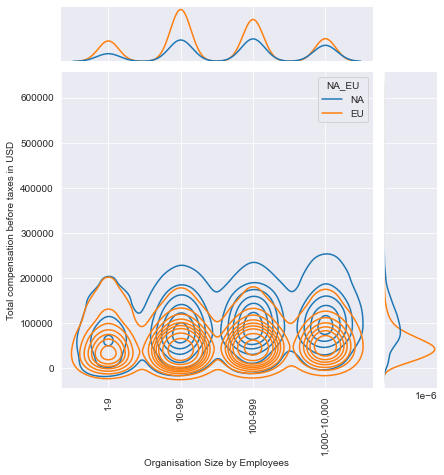

<Figure size 432x288 with 0 Axes>

In [36]:
grouper = df.groupby('Company_Size')
df['num_OrgSize'] = grouper.ngroup()

# generate x Ticklabels in the grouping order for later plotting (legend)
labels = []
for i in np.arange(0, grouper.ngroups, 1):
    mask = (df.num_OrgSize == i)
    val = np.unique(df.loc[mask, 'Company_Size'])
    if len(val) > 0:
        labels.append(val[0])
del val, mask, i

jg = sns.jointplot(data=df, x='num_OrgSize', y='ConvertedComp', 
              hue='NA_EU', color="#4CB391", kind='kde')

jg.ax_joint.set_xticks(ticks = np.unique(df.num_OrgSize));
jg.ax_joint.set_xticklabels(labels=labels, rotation=90)

jg.set_axis_labels(xlabel = 'Organisation Size by Employees', 
                   ylabel = 'Total compensation before taxes in USD');
plt.axis('auto');
plt.show()
plt.savefig('Figures/Salary_by_OrgSize.png', bbox_inches='tight', 
            pad_inches=0.1);

The next plot shows cumulative density estimates for total compensation for each continent.

In [37]:
# Generate a custom plot using a 2x3 grid of subplots
# allow plotting outside the notebook
%matplotlib qt 

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,20), 
                         sharex=True, sharey=True)
ax_idx = 0

for name, group in df.groupby('Continent'):
    # plot axes only on rightmost subplots
    legend_val = False
    if (ax_idx == 5) | (ax_idx == 2):
        legend_val = True
    
    # plot the cumulative density to the respective subplot axis
    ax = sns.ecdfplot(x=group['ConvertedComp'].values, 
                      hue=group['OrgSize'].values,
                      palette='twilight', ax=axes[ax_idx//3,ax_idx%3], 
                      legend=legend_val
                     )
    ax.set_title(name)
    ax_idx += 1
    
# save plots to current directory
plt.savefig('Figures/Income_Continent.png', bbox_inches='tight')
plt.savefig('Figures/Income_Continent.pdf', bbox_inches='tight')

# reset to plotting inside notebook
%matplotlib inline 

## Statistical testing / inference

To check whether we can support our hypothesis (there being a difference in compensation by company size), a Kruskal-Wallis test, i.e. the non-parametric version of a one-way ANOVA is calculated.

Separate tests are calculated for North America and Europe, the alpha value of each test is adjusted accordingly.

In [38]:
test_results = []
for country in ['EU', 'NA']:
    mask = df['Continent'].isin([country]);
    t_df = df.loc[mask, ['Continent', 'ConvertedComp', 'Company_Size']].copy();

    t_labels, t_vals, df_test = generate_test_values_matrix(
        data = t_df, y='ConvertedComp', str_X='Company_Size')

    # as the data does not look normally distributed, due to the long tails, 
    # we need to revert to the nonparametric alternative to a two-way ANOVA
    stat, pval = stats.kruskal(*t_vals, nan_policy='omit')
    print(country, ' - P value of Kruskal-Wallis H-Test: ', pval)
    print(country, ' - H statistic of Kruskal-Wallis Test:', stat)
    
    # get all possible group combinations
    comb = itertools.combinations(np.arange(0,len(t_labels)), 2);
    indices = [i for i in comb];
    labels = [t_labels[i[0]] + ' vs. ' + t_labels[i[1]] for i in indices];

    dfp = do_np_post_hoc_tests(t_vals, labels, indices, 0.025, True);
    test_results.append(dfp)

Number of observations for  1-9 =  1857
Number of observations for  10-99 =  4716
Number of observations for  100-999 =  3810
Number of observations for  1,000-10,000 =  2064
EU  - P value of Kruskal-Wallis H-Test:  1.155480955509377e-34
EU  - H statistic of Kruskal-Wallis Test: 160.92844416773252
Alpha value after Bonferroni correction:  0.004166666666666667 

Number of observations for  1-9 =  800
Number of observations for  10-99 =  2222
Number of observations for  100-999 =  2336
Number of observations for  1,000-10,000 =  1669
NA  - P value of Kruskal-Wallis H-Test:  1.150290044435623e-61
NA  - H statistic of Kruskal-Wallis Test: 285.84618466316834
Alpha value after Bonferroni correction:  0.004166666666666667 



## Evaluation of the results

The results from the post-hoc testing below show that except for small companies up to 100 employees in Europe, compensation is indeed higher for larger company sizes in both Europe and North America.

### Post-hoc test results for European companies

In [39]:
# formatting for Styler object to render a readable table
format_dict = {'Pval':'{:,.4f}', 'U-stat':'{:,.0f}'}

# apply format dict styling first and only to a subset of columns. Then
# apply another style to the last column, highlighting significance in green.
test_results[0].style.format(format_dict, 
                    subset = pd.IndexSlice[:, ['Pval', 'U-stat']]).applymap(
                    lambda x: "color: green" \
                    if x else "color: red", 
                    subset=pd.IndexSlice[:, ['is_significant']])

,label,Pval,U-stat,is_significant
0,1-9 vs. 10-99,0.2277,"4,327,114",False
1,1-9 vs. 100-999,0.0000,"3,238,133",True
2,"1-9 vs. 1,000-10,000",0.0000,"1,600,996",True
3,10-99 vs. 100-999,0.0000,"8,222,356",True
4,"10-99 vs. 1,000-10,000",0.0000,"4,002,932",True
5,"100-999 vs. 1,000-10,000",0.0000,"3,540,446",True


Show median and percentiles to determine the direction of the difference

In [40]:
dft = df[df['Continent'] == 'EU'].copy()
dft.groupby(by=['Company_Size'], sort=True)['ConvertedComp'].describe()

,count,mean,std,min,25%,50%,75%,max
Company_Size,,,,,,,,
1-9,1857.0,60209.082391,64741.556848,0.0,25944.0,44100.0,71340.0,596700.0
10-99,4716.0,59634.866200,71883.361229,0.0,29832.0,45396.0,64859.0,613656.0
100-999,3810.0,61835.450656,66939.330668,0.0,33924.0,48936.0,68507.0,609672.0
"1,000-10,000",2064.0,67099.774709,65248.448244,0.0,37620.0,54089.0,76329.0,604932.0


### Post-hoc test results for North American companies

In [41]:
test_results[1].style.format(format_dict)
test_results[1].style.format(format_dict, 
                    subset = pd.IndexSlice[:, ['Pval', 'U-stat']]).applymap(
                    lambda x: "color: green" \
                    if x else "color: red", 
                    subset=pd.IndexSlice[:, ['is_significant']])

,label,Pval,U-stat,is_significant
0,1-9 vs. 10-99,0.0000,"753,256",True
1,1-9 vs. 100-999,0.0000,"682,333",True
2,"1-9 vs. 1,000-10,000",0.0000,"437,842",True
3,10-99 vs. 100-999,0.0000,"2,232,660",True
4,"10-99 vs. 1,000-10,000",0.0000,"1,428,193",True
5,"100-999 vs. 1,000-10,000",0.0000,"1,756,530",True


Show median and percentiles to determine the direction of the difference

In [42]:
dft = df[df['Continent'] == 'NA'].copy()
dft.groupby(by=['Company_Size'], sort=True)['ConvertedComp'].describe()

,count,mean,std,min,25%,50%,75%,max
Company_Size,,,,,,,,
1-9,800.0,88088.035000,77897.513295,0.0,38688.00,72000.0,120000.0,600000.0
10-99,2222.0,95581.504050,59303.548216,0.0,60000.00,88000.0,122750.0,589920.0
100-999,2336.0,105196.283390,52977.982219,0.0,71069.75,100000.0,133250.0,576000.0
"1,000-10,000",1669.0,120653.324745,74123.566837,0.0,78000.00,105884.0,142700.0,600000.0


### Additional visualizations for the blog post

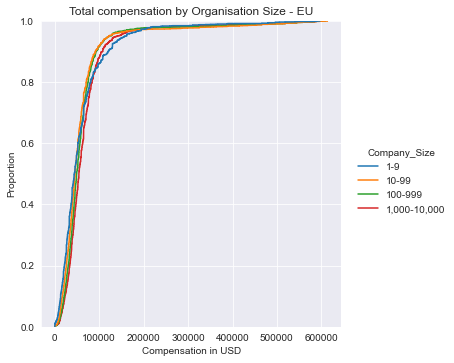

In [43]:
mask = df['Continent'].isin(['EU']);
t_df = df.loc[mask, ['Continent', 'ConvertedComp','Company_Size']].copy()

sns.displot(data=t_df, x='ConvertedComp', hue='Company_Size', kind='ecdf')
plt.title('Total compensation by Organisation Size - EU');
plt.xlabel('Compensation in USD');
plt.savefig('Figures/EU_Compansation_by_CompanySize.png', bbox_inches='tight')

# clear variables we no longer need
# del comparisons, indices, test_values, name, group, statistic, pvalue, df, i
del t_df, mask

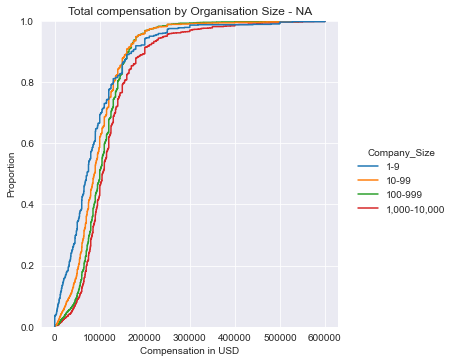

In [44]:
mask = df['Continent'].isin(['NA']);
t_df = df.loc[mask, ['Continent', 'ConvertedComp','Company_Size']].copy()

sns.displot(data=t_df, x='ConvertedComp', hue='Company_Size', kind='ecdf')
plt.title('Total compensation by Organisation Size - NA');
plt.xlabel('Compensation in USD');
plt.savefig('Figures/NA_Compansation_by_CompanySize.png', bbox_inches='tight')

# clear variables we no longer need
# del comparisons, indices, test_values, name, group, statistic, pvalue, df, i
del t_df

# Question 3 - do people with a PhD receive higher compensation than people with either another university degree or people without any university degree?

## Additional Data Preparation

In [45]:
df = dfs.copy()
# generate a copy of the filtered dataframe
df = df.loc[df.Continent.isin(['EU','NA'])];
df = df.loc[df.MainBranch == 'I am a developer by profession'];

# filter out people working in academia as payment is usually regulated 
# differently than in a company for them
df = df.loc[dfs['DevType_Academic researcher'] == 0];

# we are only interested in the comparison of PhD vs. all other types of
# higher / university education, we need to create a predictor column based
# on the dummy columns (each contains only 0, 1 or NaN)
df['PhD_vs_HigherEd'] =  df.HigherEd + df.EdLevel_Doctorate;

# assign human-readable labels for plotting
df.PhD_vs_HigherEd.replace({0:'no university Ed', 1:'Higher Ed', 
                            2:'Doctorate'}, inplace=True)

## Data Understanding

Visualizing the compensation in Europe and North America as a function of Educational Level seems to indicate differences that are more pronounced in North America than in Europe:
- While around 40% of people with a PhD earn ca. 250.000 Dollars or more, it is only about 20% for people with a higher or with no university education.
- Curves for university education or not do not differ as much

For Europe, the line for "no university education" is slightly left of the other two, but differences seem small.

In [46]:
# deactivate inline plotting
%matplotlib qt 
jg = sns.displot(data=df, x='ConvertedComp', hue='PhD_vs_HigherEd', 
            col='Continent', kind='ecdf')

jg.set_xlabels(label = 'Compensation before taxes in USD');
jg.set_ylabels(label = 'Proportion of data');

jg.tight_layout()
plt.show()
plt.savefig('Figures/Salary_by_Education.png', bbox_inches='tight', 
            pad_inches=0.3)

# reactivate inline plotting
%matplotlib inline 

## Statistical Analysis / Inference

In order to test whether the visual impressions are justified by the data, a nested or mixed-model Analysis of Variance is calculated with with *Continent* as between-subjects factor and *Education Level* as within-subjects factor

In [47]:
tdf = df[['ConvertedComp', 'PhD_vs_HigherEd', 'Continent', 'YearsCodePro']].copy()
tdf = tdf.reset_index(drop=True)
tdf['Subject'] = tdf.index
tdf.dropna(how='any', axis=0, inplace=True)

In [48]:
mixed_anova(data=tdf, 
            dv='ConvertedComp', 
            within='Continent',
            subject='Subject', 
            between='PhD_vs_HigherEd', 
            correction='auto')

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,PhD_vs_HigherEd,5.027725e+11,2,12378,2.513862e+11,14.299928,6.263017e-07,0.002305,NaN
1,Continent,1.123192e+13,1,12378,1.123192e+13,-1158.074226,1.000000e+00,-0.103216,1.0
2,Interaction,-2.315196e+11,2,12378,-1.157598e+11,11.935493,6.629383e-06,0.001925,NaN


### Evaluation of the results
The results show a significant interaction effect, which is why the main effects are not interpreted here. Visualization of the interaction (see below) suggests that the difference in compensation for people with a PhD is higher in North America as compared to Europe.

However, a separate analysis on the professional coding experience shows that PhDs from both continents tend to have more coding experience than people from the other groups, which might have biased results from the first test.

So without more sophisticated analyses, the answer to the question would be that the data do support the assumption that people with a PhD receive higher compensation at least in North America, the reason, however, might not be their title but the higher professional coding experience present in the data sample.

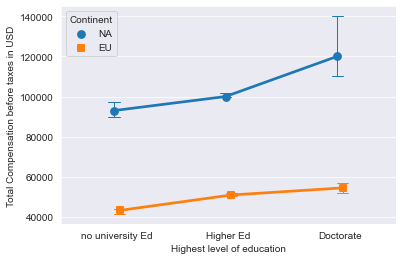

In [49]:
sns.pointplot(data=tdf, x='PhD_vs_HigherEd', y='ConvertedComp', 
              hue='Continent', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, 
              order=['no university Ed', 'Higher Ed', 'Doctorate'],
              ci = 90,
              estimator=np.median)
plt.xlabel('Highest level of education')
plt.ylabel('Total Compensation before taxes in USD')
plt.savefig('Figures/Salary_by_EducationLevel_Pointplot.png', 
            bbox_inches='tight', 
            pad_inches=0.3)

As we saw in the preprocessing part that the number of years people have been coding professionally is highly and positively correlated with compensation, a separate analysis with *Years of professional coding experience* is run in the next two cells:

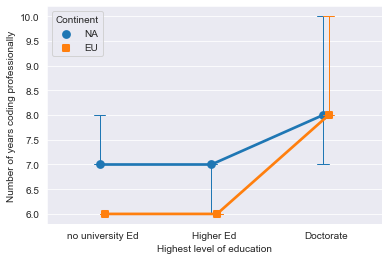

In [50]:
sns.pointplot(data=tdf, x='PhD_vs_HigherEd', y='YearsCodePro', 
              hue='Continent', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, 
              order=['no university Ed', 'Higher Ed', 'Doctorate'],
              estimator=np.median)
plt.xlabel('Highest level of education')
plt.ylabel('Number of years coding professionally')
plt.savefig('Figures/YearsCodePro_by_EducationLevel_Pointplot.png', 
            bbox_inches='tight', 
            pad_inches=0.3)

In [51]:
mixed_anova(data=tdf, 
            dv='YearsCodePro', 
            within='Continent',
            subject='Subject', 
            between='PhD_vs_HigherEd', 
            correction='auto')

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,PhD_vs_HigherEd,2620.762521,2,12378,1310.381261,8.529000,0.000199,0.001376,NaN
1,Continent,2858.558602,1,12378,2858.558602,-36.995970,1.000000,-0.002998,1.0
2,Interaction,1371.439611,2,12378,685.719805,-8.874707,1.000000,-0.001436,NaN


The results indeed indicate that the observed effect for PhD might be confounded by the higher number of professional coding experience.